In [130]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Download the image_predictions.tsv from the host
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

# Create our file and save it 
with open('image-predictions.tsv', mode='wb') as file:
    file.write(r.content)

In [3]:
# Set Up twitter authentication

## Use this space to set up your API key for reproducibility


auth = tweepy.OAuth2BearerHandler(bearer_token)
api = tweepy.API(auth)

In [4]:
# We need the list of id's to extract the info from.
df_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
df_pred = pd.read_csv('image-predictions.tsv', sep = '\t', engine = 'python')
tweet_ids = list(df_enhanced['tweet_id'])

# Define a function for extracting the info that we need
def extract_tweet_info(id):
    dict = {}
    info = api.get_status(id)._json
    dict['id'] = info['id']
    dict['retweet_count'] = info['retweet_count']
    dict['favorite_count'] = info['favorite_count']
    return dict

# Create the file, open it and write the information that we need 
with open('tweet_json.txt', mode = 'w') as file:
    for id in tweet_ids:
        try:
            tweet = extract_tweet_info(id)
            json.dump(tweet, file)
            file.write('\n')
        except:
            continue

# tweet.retweet_count
# tweet.favorite_count


In [4]:
# Load our Json data to a dataframe
df_json = pd.read_json('tweet_json.txt', lines= True)

## Assesing Data

In [11]:
df_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In order to keep the notebook tidy and short, I'll add on the next code block all the code that I've used to explore the data. I'll leave it commented to avoid a really large notebook. Feel free to use it.

In [13]:

# df_enhanced[df_enhanced['in_reply_to_status_id'].notnull()]
# df_enhanced[df_enhanced['retweeted_status_id'].notnull()]
# df_enhanced.iloc[0].source
# df_enhanced.source.value_counts()
# df_enhanced.doggo.value_counts()
# df_enhanced.expanded_urls.isnull().sum()
# df_enhanced.duplicated().sum()
# len(df_enhanced.tweet_id.unique())


### Quality Issues
1. We have a lot of Retweets in the database. We can see that we have 181 Rts.
2. We also have 78 Tweets that are actually responses to the original tweets.
3. We have extra text on the source column, not categorising it correctly.
4. Wrong data types on Timestamp columns.
5. We have 745 rows without name.
6. Wrong data type on id columns. (should be integer)
7. There are 59 expanded_urls values missing.
8. Wrong category on the dogs columns. Should be category once fixed.

### Tidiness Issues
1. There are 4 columns to identify the kind of dog.
2. We should have just 2 tables (tweets and predictions).

## Cleaning Data

In [99]:
# First of all, make a copy of all the data.
enhanced_clean = df_enhanced.copy()
json_clean = df_json.copy()
pred_clean = df_pred.copy()

### Issue #1

#### Define

We need to remove all the retweeets that we have on the data, deleting the ones that have an id on the field retweeted_status_id

#### Code

In [100]:
# We take only the data for tweets that are not retweeted.
enhanced_clean = enhanced_clean[enhanced_clean['retweeted_status_id'].isnull()]

#### Test

In [101]:
# We confirm that we the size of the resulting df is 2365 (original) minus 181 Rts
enhanced_clean.shape[0]

2175

In [102]:
# We can also check that there are no retweets left
enhanced_clean.retweeted_status_id.notnull().sum()

0

### Issue #2

#### Define
We need to delete the tweets with responses to the original tweets. We can identify them by having non-null in_reply_to_status_id
#### Code

In [103]:
# Remove the tweets with a not null response id
enhanced_clean = enhanced_clean[enhanced_clean['in_reply_to_status_id'].isnull()]

#### Test

In [104]:
# We check the size of the new df. Should be 2175 - 78
enhanced_clean.shape[0]

2097

In [105]:
# We can also check that there are no response id left
enhanced_clean.retweeted_status_id.notnull().sum()

0

### Issue #3
#### Define
We need to remove all the extra text on the source column so that we can properly categorise the origin.

#### Code

In [106]:
# First we check the options that we have
enhanced_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [107]:
# We can see that there are 2 options, twitter or vine
# We'll extract the column and loop through it to just say twitter or vine with a list comprehension
source = enhanced_clean.source

source_clean = ['Twitter' if 'twitter' in str(value) else 'Vine' for index,value in source.items()]

# Substitute the original column for the new one
enhanced_clean.source = source_clean

#### Test

In [108]:
enhanced_clean.source.value_counts()

Twitter    2006
Vine         91
Name: source, dtype: int64

### Issue #4
#### Define
Convert time-stamp columns to correct data type.

#### Code

In [109]:
# First of all, I'm going to check if I can eliminate the trailing zeros
check = enhanced_clean.timestamp.str[-5:]
check.value_counts()

+0000    2097
Name: timestamp, dtype: int64

In [110]:
# All of the 0s seem to be 0, so we'll eliminate them
new_datetime = enhanced_clean.timestamp.str[:-5]
# Substitute the new column
enhanced_clean.timestamp = new_datetime

In [111]:
# Now, let's cast the data as datetime
enhanced_clean.timestamp = pd.to_datetime(enhanced_clean.timestamp, yearfirst= True)


#### Test

In [112]:
enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2097 non-null   int64         
 1   in_reply_to_status_id       0 non-null      float64       
 2   in_reply_to_user_id         0 non-null      float64       
 3   timestamp                   2097 non-null   datetime64[ns]
 4   source                      2097 non-null   object        
 5   text                        2097 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2094 non-null   object        
 10  rating_numerator            2097 non-null   int64         
 11  rating_denominator          2097 non-null   int64       

### Issue #5
#### Define
Investigate if the data is missing due to a quality problem or due to lack of data. We will then impute information from the text or leave the data as is.

#### Code

In [113]:
# Let's check first if there has been change in the number of rows affected after the changes.
enhanced_clean[enhanced_clean.name == 'None']['text']

5       Here we have a majestic great white breaching ...
7       When you watch your owner call another dog a g...
12      Here's a puppo that seems to be on the fence a...
24      You may not have known you needed to see this ...
25      This... is a Jubilant Antarctic House Bear. We...
                              ...                        
2342    Here we have a well-established sunblockerspan...
2343    Let's hope this flight isn't Malaysian (lol). ...
2344    Here we have a northern speckled Rhododendron....
2351    Here we have a 1949 1st generation vulpix. Enj...
2355    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 603, dtype: object

In [114]:
enhanced_clean.iloc[7]['text']

"When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq"

#### Test

We can see that the data is actually correct and the tweets do not offer information about the name of the dog. We'll leave then the data as is

### Issue #6
#### Define
Now that we have eliminated the response and retweet columns, there is no longer need for those columns, so we'll drop them from the dataframe

#### Code

In [115]:
enhanced_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp'], axis = 1, inplace= True)

#### Test

In [116]:
enhanced_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### Issue #7
#### Define
There are missing values in the expanded_url field. We will use string concatenation to fill the gaps.

#### Code

In [117]:
# Establish first part of string
handle = 'https://twitter.com/dog_rates/status/'
# Extract our tweet ids
ids = enhanced_clean.tweet_id
# List comprehension to create the full list of urls
expanded_urls = [handle + str(value) for index,value in ids.items()]
# Substitute the full list of urls in expanded_urls column
enhanced_clean.expanded_urls = expanded_urls

#### Test

In [118]:
enhanced_clean.expanded_urls.isnull().sum()

0

### Data Quality Issue #8 + Data tidiness Issue #1
#### Define
We will be creating just one column for dogs categories instead of four. Afterwards, we'll configure the field as category

#### Code

In [119]:
# We make a copy of our data
enhanced_dog_type = enhanced_clean.copy()
# Drop all the columns that are not related to the kind of dog
enhanced_dog_type.drop(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name'], axis = 1, inplace = True)

# Replace None strings with NaN so to backfill correctly
enhanced_dog_type.replace(to_replace='None',value = np.nan, inplace = True)

# Backfill a column with the data of the four columns
enhanced_dog_type['coalesce'] = enhanced_dog_type.bfill(axis = 1).iloc[:,0]
# Substitute the data on a new column a drop the unnecesary columns
enhanced_clean['dog_type'] = enhanced_dog_type['coalesce']
enhanced_clean.drop(['doggo', 'floofer',
       'pupper', 'puppo'], axis = 1, inplace= True)

#### Test

In [120]:
enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   int64         
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2097 non-null   object        
 5   rating_numerator    2097 non-null   int64         
 6   rating_denominator  2097 non-null   int64         
 7   name                2097 non-null   object        
 8   dog_type            336 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 163.8+ KB


### Data tidiness Issue #2
#### Define
Merge the table enhanced_clean con json_clean to have all the data about the tweets in just one place.

#### Code

In [121]:
# we rename the column on the json dataframe to tweet_id
json_clean.rename({'id': 'tweet_id'}, inplace= True, axis = 1)
#Join both dataframes
final_enhanced = pd.merge(enhanced_clean, json_clean, left_on = 'tweet_id', right_on = 'tweet_id', how = 'left')

# Ensure data types
final_enhanced = final_enhanced.astype({'retweet_count': 'Int64', 'favorite_count': 'Int64'})

#### Test

In [122]:
final_enhanced.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,6894,32963
1,892177421306343426,2017-08-01 00:17:27,Twitter,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,5193,28507
2,891815181378084864,2017-07-31 00:18:03,Twitter,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,3427,21435
3,891689557279858688,2017-07-30 15:58:51,Twitter,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,7103,35974
4,891327558926688256,2017-07-29 16:00:24,Twitter,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,7621,34386


## Storing Data

We will be storing our dataframe in a CSV file

In [124]:
# Stored in CSV 
final_enhanced.to_csv('twitter_archive_master.csv')

# Stored in DDBB
from sqlalchemy import create_engine
engine = create_engine('sqlite:///twitter_archive_master.db')

final_enhanced.to_sql('master', engine, index=False)

2097

## Analyzing Data

### Insights

1. Retweets and Favorites are not correlated.

We can see that, while puppo is a clear winner in the favorite count, it's tied in the retweet count. Which leads us to believe that users understand and use both features in a completely different manner.

In [125]:
final_enhanced.groupby('dog_type').mean()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count
dog_type,,,,,
doggo,7.948089e+17,11.771084,10.0,4510.052632,15276.964912
floofer,7.558218e+17,11.888889,10.0,6696.333333,19097.666667
pupper,7.185927e+17,10.805430,10.0,4594.275,16690.875
puppo,8.079175e+17,12.000000,10.0,6692.294118,24091.294118


2. The main source of meadia is twitter, while vine is a residual second place. 

The incorporation of video and photo as media in twitter has made the need to embed content from outside platforms completely redundant as we can see below.

In [89]:
final_enhanced.source.value_counts()

Twitter    2006
Vine         91
Name: source, dtype: int64

3. There's no correlation between the type of dog and the number of favorites that the users give a tweet.

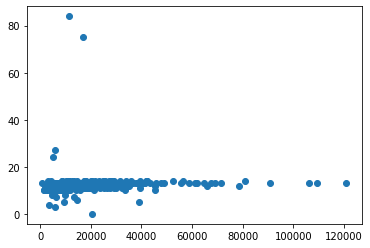

In [129]:
#Extract the data that has favorite count not null
plot_enhanced = final_enhanced[final_enhanced['favorite_count'].notnull()]
plt.scatter(y= plot_enhanced.rating_numerator, x = plot_enhanced.favorite_count, )